# Micrograd

Micrograd is a tiny Autograd engine to demonstrate backpropagation in reverse auto-diff mode.

Backpropagation is just an application of the chain-rule of differentiation.     
It does not care about neural networks.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
 
from micrograd_utils import draw_dot

H = 0.000001

### The `Value` class

In [26]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        """
        data is the value of the node.
        _prev tracks the parents of the node in the computational graph.
        _op tracks the operations which created the node from the parents.
        _backward is a function that performs backprop locally given the inputs and outputs at a node.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # Default backward pass to no-op, say for leaf nodes.
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        __repr__() is a Python magic method that returns a printable representation of the object.
        """
        return f"Value(data={self.data})"

    def __add__(self, other):
        """
        __add__() defines the behavior of the addition operator (+).
        """
        # This pre-processing step allows us to add a Value to a number.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op="+")

        def _backward():
            #self.grad = 1.0 * out.grad
            # Accumulate gradients instead of setting them, to account for the same node being used multiple times,
            # to allow for multiple backward passes through multiple paths in the computational graph.
            self.grad += 1.0 * out.grad
            #other.grad = 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        """
        __mul__() defines the behavior of the multiplication operator (*).
        """
        # This pre-processing step allows us to multiple a Value with a number.
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data*other.data, _children=(self, other), _op="*")
        
        def _backward():
            #self.grad = other.data * out.grad
            self.grad += other.data * out.grad
            #other.grad = self.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other


    def __pow__(self, other):
        """
        y=x**n
        """
        assert isinstance(other, (int, float)), "Only int/float powers supported."
        out = Value(self.data**other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    

    def __truediv__(self, other):
        """
        a/b = a * b**-1
        """
        return self * other**-1


    def __neg__(self):
        """
        out=-self
        """
        return self * -1


    def __sub__(self, other):
        """
        out=self-other
        """
        return self + (-other)


    def tanh(self):
        """
        tanh can also be built out of primitive ops after defining how exp works.
        However, we don't necessarily have to implement every primitive and
        exhaustively build things up bottom-up.
        As long as we know how to take the derivative of the function,
        we can implement any arbitrary function that we want.
        """
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op="tanh")

        def _backward():
            #self.grad = (1 - t**2) * out.grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        """
        y=e**x
        """
        x = self.data
        out = Value(math.exp(x), _children=(self, ), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
      
    def backward(self):
        """
        Public backward function to call _backward on each node in the graph
        in topologically sorted order.
        """
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


### Add support for `exp`, `truediv`, `pow`, `sub`.


In [27]:
a= Value(2.0, label="a")
b = 2+a; b.label = "b"
b

Value(data=4.0)

### Try writing tanh in 2 different ways.

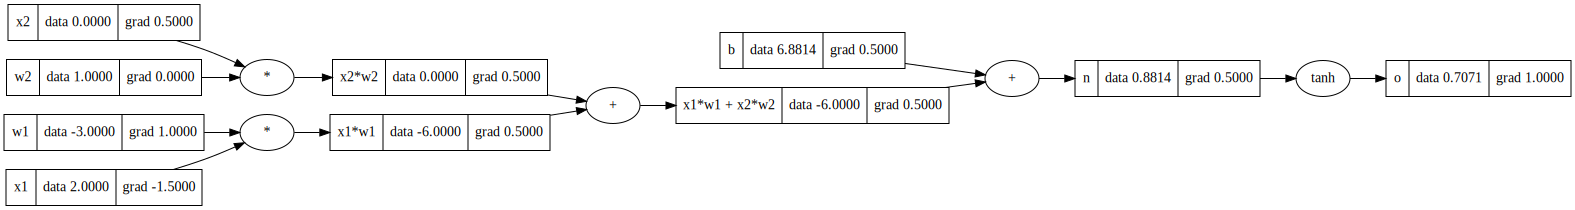

In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

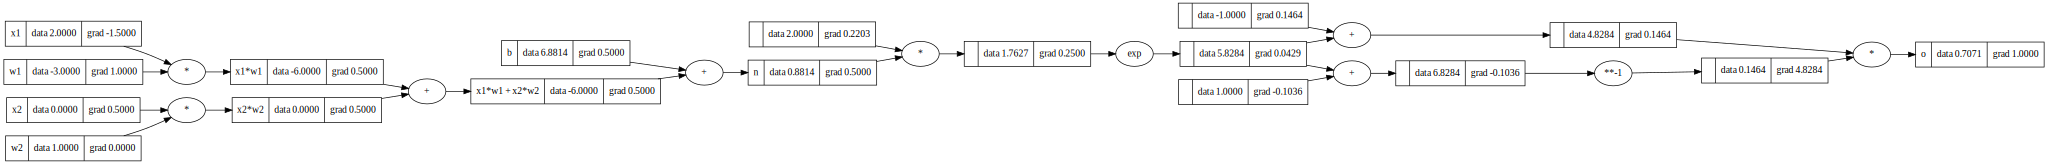

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

This demonstrates that we can break down our computational graph and implement basic ops (and their backward passes) depending on the granularity we need (`tanh` directly or decomposed into `exp`, `truediv`, `sub`).

In [30]:
import torch

x1, x2 = torch.Tensor([2.0]).double(), torch.Tensor([0.0]).double()
x1.requires_grad = True
x2.requires_grad = True

w1, w2 = torch.Tensor([-3.0]).double(), torch.Tensor([1.0]).double()
w1.requires_grad = True
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

o = torch.tanh(x1*w1 + x2*w2 + b)

print(o.data.item())
o.backward()

print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')

0.7071066904050358
x2: 0.5000001283844369
w2: 0.0
x1: -1.5000003851533106
w1: 1.0000002567688737


### Building out an MLP library.

In [33]:
import torch
import random

In [52]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

In [38]:
x = [2,3]
n = Neuron(2)
n(x)

Value(data=-0.9993291882223654)

![cs231n-mlp](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [55]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [58]:
x = [2,3]
l = Layer(2,3)
l(x)

[Value(data=0.8995593993373062),
 Value(data=-0.11830154264947465),
 Value(data=0.4153809028679024)]

In [59]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [67]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6431439462402396)

### Let's train our MLP.

In [68]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [70]:
EPOCHS = 10
LR = 0.1

for epoch in range(EPOCHS):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
      # Minimize the loss.
      p.data += -1*LR * p.grad
  
  print(f"[{epoch+1}/{EPOCHS}] Loss={loss.data:.4f}")
  

[1/10] Loss=0.0209
[2/10] Loss=0.0194
[3/10] Loss=0.0181
[4/10] Loss=0.0170
[5/10] Loss=0.0161
[6/10] Loss=0.0153
[7/10] Loss=0.0146
[8/10] Loss=0.0140
[9/10] Loss=0.0134
[10/10] Loss=0.0129
